# Определение перспективного тарифа для телеком-компании

**Цель исследования** - проанализировать поведение Клиентов на основании предоставленной выборки и опеределить какой тариф приносит больше денег компании "Мегалайн". Проверить гипотезы о том,что:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Ход исследования** - информацию о данных 500 пользователей мы получили от представителей Компании "Мегалайн".
О качестве данных ничего не известно,поэтому перед началом исследования следует провести обзор данных на предмет ошибок и их влияния на результат исследования. Затем, на этапе предобработки следует скорректировать ошибки, которые являются критическими. Далее провести анализ показателей, требующихся для исследования и расчитать недостающие и добавить их в общую таблицу.

Требуется провести анализ следующих параметров:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Описание тарифов:

**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей.
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута);
2. сообщение: 3 рубля;
3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
1. минута разговора: 1 рубль;
2. сообщение: 1 рубль;
3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Этапы исследования:
1. [Изучение данных из файла](#general_id)
2. [Предобработка данных](#preprocessing_id)
    2.1.[Замена типа данных](#preprocessing_one_id)
    2.2.[Проверка допустимых значений](#preprocessing_two_id)
    2.3.[Категоризация и группировка данных](#preprocessing_three_id)
    2.4.[Объединение,расчеты и добавление результатов в таблицу](#preprocessing_four_id)
    2.5.[Проверка допустимых значений после выполнения группировки](#preprocessing_five_id)
3. [Исследовательский анализ данных](#analysis_id)
4. [Общий вывод](#conclusion_id)


## Изучение данных из файла
<a id=general_id></a>

In [1]:
import pandas as pd
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
russian_stemmer = SnowballStemmer('russian')
pd.set_option('display.float_format', '{:,.2f}'.format)
import seaborn as sns
import numpy as np
import plotly
import plotly.express as px
from scipy.stats import norm
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv',index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Создадим функцию research для изучения данных в таблице.

In [3]:
def research (data):
    data.info(memory_usage='deep')
    display(data.head())
    display(data.describe())
    print('Количество дубликатов',data.duplicated().sum())

Изучим таблицу users

In [4]:
research(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 229.6 KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age
count,500.00,500.00
mean,"1,249.50",46.59
std,144.48,16.67
min,"1,000.00",18.00
25%,"1,124.75",32.00
50%,"1,249.50",46.00
75%,"1,374.25",62.00
max,"1,499.00",75.00


Количество дубликатов 0


В таблице **users** отражена информация о пользователях:

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифного плана

Исходя из цели исследования нам потребуются колонки: `user_id`,`city`,`tarif`.

Наименование колонок указано верно, есть пропущенные значения в колонке `churn_date`, но они свидетельствуют о том,что пользователь еще является Клиентом Компании. Из 500 пользователей,указанных в выборке 38 расторгли договора на оказание услуг связи.
Средний возраст клиента - 46 лет.
Дубликатов не обнаружено, столбцы: `churn_date`,`reg_date` не будут использоваться при проведении анализа, поэтому не будем менять тип данных на тип даты.

Изучим таблицу calls

In [5]:
research(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


Количество дубликатов 0


В таблица **calls** отражена информация о звонках:
- `id`— уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

В рамках проведения исследования нам потребуются все колонки таблицы calls.

Наименование колонок указано верно, пропущенные значения отсутствуют, дубликаты отсутствуют, типы данных укзааны верно во всех ячейка кроме `call_date` (требуется перевести в формат даты).

Так как оператор округляет количество минут в большую сторону на этапе предобработки данных следует выполнить округление значений в колонке duration.

Изучим таблицу internet

In [6]:
research(internet)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 22.2 MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,mb_used,user_id
count,"149,396.00","149,396.00"
mean,370.19,"1,252.10"
std,278.30,144.05
min,0.00,"1,000.00"
25%,138.19,"1,130.00"
50%,348.01,"1,251.00"
75%,559.55,"1,380.00"
max,"1,724.83","1,499.00"


Количество дубликатов 0


В таблице **internet** отражена информация об интернет-сессиях:
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

В рамках проведения исследования нам потребуются все колонки таблицы.

Наименование колонок указано верно, пропущенные значения отсутствуют,дубликаты не найдены, тип данных указан верно во всех столбцах кроме `session_date`(требуется перевести в формат даты). Обнаружен неизвестный столбец `Unnamed:0`.

Изучим таблицу messages

In [7]:
research(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 16.4 MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,user_id
count,"123,036.00"
mean,"1,256.99"
std,143.52
min,"1,000.00"
25%,"1,134.00"
50%,"1,271.00"
75%,"1,381.00"
max,"1,499.00"


Количество дубликатов 0


В таблице messages отражена информация о сообщениях:
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

В рамках проведения исследования нам потребуются все колонки таблицы

Пропущенные значения отсутствуют,наименование колонок указано верно,дубликатов не обнаружено требуется изменить тип данных в колонке message_date на формат даты.

Изучим таблицу tariffs

In [8]:
research(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 364.0 bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
std,671.75,"10,861.16","1,767.77",989.95,35.36,1.41,1.41
min,50.00,"15,360.00",500.00,550.00,150.00,1.00,1.00
25%,287.50,"19,200.00","1,125.00",900.00,162.50,1.50,1.50
50%,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
75%,762.50,"26,880.00","2,375.00","1,600.00",187.50,2.50,2.50
max,"1,000.00","30,720.00","3,000.00","1,950.00",200.00,3.00,3.00


Количество дубликатов 0


В таблице tariffs указана информация о тарифах:
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

В рамках проведения исследования нам потребуются все колонки таблицы.

Наименование колонки tariff_name в таблице tariffs  отличается от колонки tariff в таблице users,в рамках исследования данные таблицы будут объеденены по тарифу, в связи с чем требуется привести наименования к единообразию.


### Вывод

При изучении таблицы выявлены столбцы,которые необходимо перевести в формат даты, а именно:
- `call_date`;
- `session_date`;
- `message_date`;

В исходных таблицах предоставлена выборка по 500 Клиентам Компании за 2018 год. Представлены таблицы с информацией о пользователях, где указана фамилия, имя, идентификатор пользователя, город, возраст, дата заключения договора и дата расторжени. Также представлены таблицы с информацией о произведенных расходах: количестве звонков и их длительности, количестве смс, расходе трафика и таблица с подробной информацией о тарифных планах,которые требуется исследовать ("Смарт" и "Ультра").
Согласно цели исследования нам потребуются не все параметры таблиц. Предварительно можно утверждать,что данных для проведения анализа достаточно.
На этапе изучения данных обнаружены допустипые нулевые значения в столбце churn_date и duration, таблица проверена на наличие дубликатов.

Но перед началом исследования требуется выполнить предобработку данных: изменить типы данных,выполнить проверку допустимых значений, выполнить категоризации и только после этого провести исследование.

## Предобработка данных

### Замена типа данных
<a id="preprocessing_one_id"></a>

Выполним замену типа данных в колонках с датами,которые потребуются для исследования, на формат даты.

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%dT%H:%M:%S')

Создадим функцию optimize, которая позволяет экономить наше сетевое пространство.

In [10]:
def optimize(data):
    for dtype in ['int']:
        selected_dtype = data.select_dtypes(include=[dtype])
        selected_dtype_column = selected_dtype.columns
        for i in selected_dtype_column:
            data[i] = data[i].astype('int32')

    for dtype in ['float']:
        selected_dtype = data.select_dtypes(include=[dtype])
        selected_dtype_column = selected_dtype.columns
        for i in selected_dtype_column:
            data[i] = data[i].astype('float32')

    data.info(memory_usage='deep')

Применим ее к нашим таблицам

In [11]:
optimize(users)
print()
optimize(calls)
print()
optimize(internet)
print()
optimize(messages)
print()
optimize(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int32
age           500 non-null int32
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int32(2), object(6)
memory usage: 248.8 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float32
user_id      202607 non-null int32
dtypes: datetime64[ns](1), float32(1), int32(1), object(1)
memory usage: 15.6 MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float32
session_date    149396 non-null datetime64

Округлим количество исходящих звонков в таблице calls и приведем к типу данных int

In [12]:
calls['duration'] = np.ceil(calls['duration'].astype('float32'))
calls['duration'] = calls['duration'].astype('int32')
display(calls)
display(calls.info())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int32
user_id      202607 non-null int32
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 4.6+ MB


None

Оставим в таблице users только те солбцы, которые потребуются для проведения исследования.

In [13]:
users = users.loc[:,['user_id','city','tariff']]
display(users)

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
...,...,...,...
495,1495,Иркутск,ultra
496,1496,Вологда,smart
497,1497,Челябинск,smart
498,1498,Владикавказ,smart


Округлим количество трафика в таблице tariffs до гб,округление значений по таблице internet выполним после группировки значений по месяцам.

In [14]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
     
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.00,500,550,200,3,3,smart
1,1000,30.00,3000,1950,150,1,1,ultra


Переименуем колонку tariff_name в таблице tariffs.

In [15]:
tariffs=tariffs.rename(columns={'tariff_name':'tariff'})
display(tariffs) 

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.00,500,550,200,3,3,smart
1,1000,30.00,3000,1950,150,1,1,ultra


**Вывод**

Для дальнейшей работы столбцы с информацией о датах были приведены к формату дат.
Также была выполнена оптимизация используемой памяти путем изменения типа данных с 64 на 32.

В таблице calls было выполнено округление значений по столбцу duration в большую сторону, так как по условиям тарифа 1 секунда разговора приравнивается к минуте.

В таблице users оставлены данные,требуемые для проведения анализа.

Расчет стоимости интернет трафика производится в ГБ, в связи с этим выполним округление в таблице tariffs по столбцу трафик.

В таблице tariffs было выполнено переименование столбца tariff_name в tariff,для дальнейшего выполнения объединения таблиц users и tariffs.


### Проверка допустимых значений
<a id="preprocessing_two_id"></a>

Выполним проверку написания в наименовании городов в таблице users

In [16]:
print(users['city'].value_counts().head(40))
print(users['city'].value_counts().tail(36))

users['tariff'].value_counts()


Москва              99
Санкт-Петербург     39
Новосибирск         16
Омск                14
Казань              14
Уфа                 12
Набережные Челны    11
Екатеринбург        11
Ульяновск           11
Краснодар           11
Челябинск            9
Самара               9
Волгоград            8
Нижний Новгород      8
Пермь                8
Новокузнецк          7
Вологда              7
Улан-Удэ             7
Красноярск           7
Ростов-на-Дону       6
Воронеж              6
Сочи                 6
Тюмень               6
Киров                6
Иркутск              6
Пенза                6
Томск                6
Балашиха             5
Магнитогорск         5
Владивосток          5
Ставрополь           5
Махачкала            5
Рязань               4
Мурманск             4
Петрозаводск         4
Кострома             4
Саранск              4
Новороссийск         4
Чита                 4
Хабаровск            4
Name: city, dtype: int64
Тольятти         4
Калуга           4
Астрахань        

smart    351
ultra    149
Name: tariff, dtype: int64

Наименования городов указаны верно, а также в таблице указано 2 варианта тарифов.

 Проверим длительность звонков.

In [17]:
calls['call_date'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

Проверим значения дат в таблицах.


In [18]:
calls['call_date'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

In [19]:
internet['session_date'].describe()

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

In [20]:
messages['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

In [21]:
internet['mb_used'].value_counts()

0.00      19598
447.30        9
335.91        9
197.56        9
461.19        8
          ...  
605.07        1
666.20        1
803.64        1
342.36        1
868.08        1
Name: mb_used, Length: 70003, dtype: int64

In [22]:
#internet[internet['mb_used']==0]
internet[internet['mb_used']==0]
internet[internet['user_id']==1000]
print(internet.sort_values(by='session_date').query('user_id ==1499').head(40))

              id  mb_used session_date  user_id
149297   1499_58     6.56   2018-09-28     1499
149337   1499_98 1,138.32   2018-09-29     1499
149351  1499_112   339.69   2018-09-29     1499
149249   1499_10     0.00   2018-09-29     1499
149374  1499_135   361.18   2018-09-30     1499
149255   1499_16   513.05   2018-10-02     1499
149298   1499_59   191.83   2018-10-02     1499
149250   1499_11   597.76   2018-10-03     1499
149260   1499_21   436.23   2018-10-03     1499
149323   1499_84   164.42   2018-10-03     1499
149391  1499_152   318.90   2018-10-03     1499
149340  1499_101   881.51   2018-10-03     1499
149262   1499_23     0.00   2018-10-04     1499
149335   1499_96   257.39   2018-10-04     1499
149334   1499_95   271.53   2018-10-05     1499
149317   1499_78   805.98   2018-10-05     1499
149282   1499_43   518.57   2018-10-05     1499
149244    1499_5   227.09   2018-10-05     1499
149345  1499_106     0.00   2018-10-05     1499
149366  1499_127     0.00   2018-10-06  

**Вывод**

При изучении уникальных значений в таблице users в наименовании городов и тарифах ошибок не обнаружено.
В колонках с информацией о датах указан 2018 год.

Требуется изучить выбросы по длительности звонка, количеству используемого трафика и израсходованных смс после выполнения группировки по пользователям и месяцам.


### Категоризация и группировка данных
<a id="preprocessing_three_id"></a>

Исходя из условий тарифа пакет услуг предоставлется на месяц, в связи с этим требуется добавить категорию по месяцам.
Чтобы выполнить проверку допустимых значений

In [23]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

Выполним группировку по месяцам во всех таблицах

In [24]:
calls_pivot = calls.groupby(['user_id','month'])['duration'].sum()
calls_pivot = calls_pivot.reset_index(drop=False)
print(calls_pivot)

      user_id  month  duration
0        1000      5       159
1        1000      6       172
2        1000      7       340
3        1000      8       408
4        1000      9       466
...       ...    ...       ...
3169     1498     10       247
3170     1499      9        70
3171     1499     10       449
3172     1499     11       612
3173     1499     12       492

[3174 rows x 3 columns]


In [25]:
internet_pivot = internet.groupby(['user_id','month'])['mb_used'].sum()
internet_pivot = internet_pivot.reset_index(drop=False)
print(internet_pivot)


      user_id  month   mb_used
0        1000      5  2,253.49
1        1000      6 23,233.77
2        1000      7 14,003.64
3        1000      8 14,055.93
4        1000      9 14,568.91
...       ...    ...       ...
3198     1498     10 20,579.36
3199     1499      9  1,845.75
3200     1499     10 17,788.51
3201     1499     11 17,963.31
3202     1499     12 13,055.58

[3203 rows x 3 columns]


In [26]:
messages_pivot = messages.groupby(['user_id','month'])['message_date'].count()
messages_pivot = messages_pivot.reset_index(drop=False)
print(messages_pivot)


      user_id  month  message_date
0        1000      5            22
1        1000      6            60
2        1000      7            75
3        1000      8            81
4        1000      9            57
...       ...    ...           ...
2712     1498     10            42
2713     1499      9            11
2714     1499     10            48
2715     1499     11            59
2716     1499     12            66

[2717 rows x 3 columns]


**Вывод**

Для проведения анализа были добавлены категории по месяцам и выполнена группировка по месяцам и пользователям.

### Объединение таблиц, расчеты и добавление данных в таблицу
<a id="preprocessing_four_id"></a>

Объединим таблицы в одну.

In [27]:
pivot = calls_pivot.merge(internet_pivot,on=['user_id','month'], how='outer')
pivot = pivot.merge(messages_pivot,on=['user_id','month'], how='outer')
pivot = pivot.merge(users,on=['user_id'], how='outer')
pivot = pivot.merge(tariffs,on=['tariff'], how='outer')

display(pivot.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
duration                 3174 non-null float64
mb_used                  3203 non-null float32
message_date             2717 non-null float64
city                     3216 non-null object
tariff                   3216 non-null object
messages_included        3216 non-null int32
mb_per_month_included    3216 non-null float64
minutes_included         3216 non-null int32
rub_monthly_fee          3216 non-null int32
rub_per_gb               3216 non-null int32
rub_per_message          3216 non-null int32
rub_per_minute           3216 non-null int32
dtypes: float32(1), float64(4), int32(6), int64(1), object(2)
memory usage: 288.9+ KB


None

Приведем наименование колонок к единообразию и выполним округление по столбцу traffic в соответствии с условием тарифа.

In [28]:
pivot=pivot.rename(columns={'duration':'calls','mb_used':'traffic','message_date':'message'})
display(pivot.info())                  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
calls                    3174 non-null float64
traffic                  3203 non-null float32
message                  2717 non-null float64
city                     3216 non-null object
tariff                   3216 non-null object
messages_included        3216 non-null int32
mb_per_month_included    3216 non-null float64
minutes_included         3216 non-null int32
rub_monthly_fee          3216 non-null int32
rub_per_gb               3216 non-null int32
rub_per_message          3216 non-null int32
rub_per_minute           3216 non-null int32
dtypes: float32(1), float64(4), int32(6), int64(1), object(2)
memory usage: 288.9+ KB


None

Заменим образовавшиеся пропуски после объединения на 0 в столбцах calls,traffic,message,месяцам.


In [29]:
pivot['calls']=pivot['calls'].fillna(0)
pivot['traffic']=pivot['traffic'].fillna(0)
pivot['message']=pivot['message'].fillna(0)
pivot['month']=pivot['month'].fillna(0)
display(pivot.info())  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
user_id                  3216 non-null int64
month                    3216 non-null float64
calls                    3216 non-null float64
traffic                  3216 non-null float32
message                  3216 non-null float64
city                     3216 non-null object
tariff                   3216 non-null object
messages_included        3216 non-null int32
mb_per_month_included    3216 non-null float64
minutes_included         3216 non-null int32
rub_monthly_fee          3216 non-null int32
rub_per_gb               3216 non-null int32
rub_per_message          3216 non-null int32
rub_per_minute           3216 non-null int32
dtypes: float32(1), float64(4), int32(6), int64(1), object(2)
memory usage: 288.9+ KB


None

In [30]:
pivot['traffic'] = pivot['traffic']/1024
pivot['traffic']  = np.ceil(pivot['traffic'].astype('float32')) 
display(pivot)

,user_id,month,calls,traffic,message,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.00,159.00,3.00,22.00,Краснодар,ultra,1000,30.00,3000,1950,150,1,1
1,1000,6.00,172.00,23.00,60.00,Краснодар,ultra,1000,30.00,3000,1950,150,1,1
2,1000,7.00,340.00,14.00,75.00,Краснодар,ultra,1000,30.00,3000,1950,150,1,1
3,1000,8.00,408.00,14.00,81.00,Краснодар,ultra,1000,30.00,3000,1950,150,1,1
4,1000,9.00,466.00,15.00,57.00,Краснодар,ultra,1000,30.00,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.00,0.00,17.00,32.00,Санкт-Петербург,smart,50,15.00,500,550,200,3,3
3212,1489,10.00,0.00,20.00,21.00,Санкт-Петербург,smart,50,15.00,500,550,200,3,3
3213,1489,11.00,0.00,18.00,20.00,Санкт-Петербург,smart,50,15.00,500,550,200,3,3
3214,1489,12.00,0.00,17.00,35.00,Санкт-Петербург,smart,50,15.00,500,550,200,3,3


In [31]:
pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
user_id                  3216 non-null int64
month                    3216 non-null float64
calls                    3216 non-null float64
traffic                  3216 non-null float32
message                  3216 non-null float64
city                     3216 non-null object
tariff                   3216 non-null object
messages_included        3216 non-null int32
mb_per_month_included    3216 non-null float64
minutes_included         3216 non-null int32
rub_monthly_fee          3216 non-null int32
rub_per_gb               3216 non-null int32
rub_per_message          3216 non-null int32
rub_per_minute           3216 non-null int32
dtypes: float32(1), float64(4), int32(6), int64(1), object(2)
memory usage: 288.9+ KB


Создадим дополнительные колонки с количеством расходов сверх тарифа.

In [32]:
pivot['calls_over'] = pivot['calls']-pivot['minutes_included']
pivot['traffic_over'] = pivot['traffic']-pivot['mb_per_month_included']
pivot['message_over'] = pivot['message']-pivot['messages_included']

for i in pivot['calls_over']:
    if i<0:
        pivot['calls_over']=pivot['calls_over'].replace(i,0)

for i in pivot['traffic_over']:
    if i<0:
        pivot['traffic_over']=pivot['traffic_over'].replace(i,0)
        
for i in pivot['message_over']:
    if i<0:
        pivot['message_over']=pivot['message_over'].replace(i,0)
        
        

print(pivot.describe())

       user_id    month    calls  traffic  message  messages_included  \
count 3,216.00 3,216.00 3,216.00 3,216.00 3,216.00           3,216.00   
mean  1,251.59     8.31   450.96    17.29    38.26             341.26   
std     144.65     2.91   242.10     7.41    36.15             438.09   
min   1,000.00     0.00     0.00     0.00     0.00              50.00   
25%   1,125.00     6.00   282.00    13.00     9.00              50.00   
50%   1,253.00     9.00   443.00    17.00    30.00              50.00   
75%   1,378.25    11.00   589.00    21.00    57.00           1,000.00   
max   1,499.00    12.00 1,673.00    49.00   224.00           1,000.00   

       mb_per_month_included  minutes_included  rub_monthly_fee  rub_per_gb  \
count               3,216.00          3,216.00         3,216.00    3,216.00   
mean                   19.60          1,266.48           979.23      184.67   
std                     6.92          1,152.88           645.61       23.06   
min                    15.

Рассчитаем выручку по каждому клиенту.

In [33]:
pivot['revenue'] = pivot['rub_monthly_fee'] + pivot['calls_over']*pivot['rub_per_minute'] + pivot['message_over']*pivot['rub_per_message']+pivot['traffic_over']*pivot['rub_per_gb']

display(pivot.describe())

,user_id,month,calls,traffic,message,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over,traffic_over,message_over,revenue
count,"3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00","3,216.00"
mean,"1,251.59",8.31,450.96,17.29,38.26,341.26,19.60,"1,266.48",979.23,184.67,2.39,2.39,28.84,2.32,4.02,"1,528.90"
std,144.65,2.91,242.10,7.41,36.15,438.09,6.92,"1,152.88",645.61,23.06,0.92,0.92,73.06,3.51,11.51,798.22
min,"1,000.00",0.00,0.00,0.00,0.00,50.00,15.00,500.00,550.00,150.00,1.00,1.00,0.00,0.00,0.00,550.00
25%,"1,125.00",6.00,282.00,13.00,9.00,50.00,15.00,500.00,550.00,150.00,1.00,1.00,0.00,0.00,0.00,750.00
50%,"1,253.00",9.00,443.00,17.00,30.00,50.00,15.00,500.00,550.00,200.00,3.00,3.00,0.00,0.00,0.00,"1,653.50"
75%,"1,378.25",11.00,589.00,21.00,57.00,"1,000.00",30.00,"3,000.00","1,950.00",200.00,3.00,3.00,0.00,4.00,0.00,"1,950.00"
max,"1,499.00",12.00,"1,673.00",49.00,224.00,"1,000.00",30.00,"3,000.00","1,950.00",200.00,3.00,3.00,935.00,23.00,93.00,"6,770.00"


**Вывод**

Для проведения анализа было выполнено объединение исходных таблиц, так как после объединения образовались пропуски они были заменены на 0.
Далее в таблицу были добавлены дополнительные столбцы calls_over, traffic_over, message_over с информацией о превышении тарифа для выполнения расчета по столбцу с рассчитанной выручкой revenue.

### Проверка допустимых значений после выполнения группировки
<a id="preprocessing_five_id"></a>

Выполним проверку допустимых значений по количеству израсходованных звонков, трафика, сообщений.

count   3,216.00
mean      450.96
std       242.10
min         0.00
25%       282.00
50%       443.00
75%       589.00
max     1,673.00
Name: calls, dtype: float64

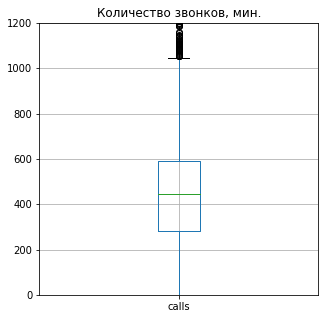

In [34]:
pivot.boxplot(column='calls',figsize=(5,5))
plt.ylim(0, 1200)
plt.title("Количество звонков, мин.")
pivot['calls'].describe()

Исходя из распределения по звонкам можно сделать вывод,что количество звонков свыше 1020 являются выбросами.

count   3,216.00
mean       17.29
std         7.41
min         0.00
25%        13.00
50%        17.00
75%        21.00
max        49.00
Name: traffic, dtype: float64

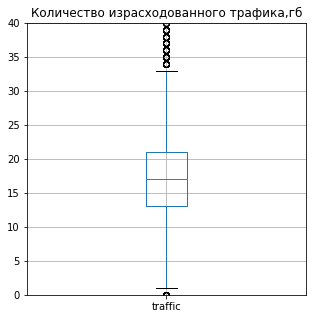

In [35]:
pivot.boxplot(column='traffic',figsize=(5,5))
plt.ylim(0, 40)
plt.title("Количество израсходованного трафика,гб")
pivot['traffic'].describe()

Исходя из распределения можно отнести расходы по трафику свыше 33 гб к выбросам.

count   3,216.00
mean       38.26
std        36.15
min         0.00
25%         9.00
50%        30.00
75%        57.00
max       224.00
Name: message, dtype: float64

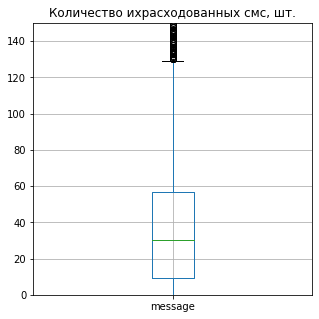

In [36]:
pivot.boxplot(column='message',figsize=(5,5))
plt.ylim(0, 150)
plt.title("Количество ихрасходованных смс, шт.")
pivot['message'].describe()

Отправка пользователем свыше 130 сообщений - это скорее исключение.

count   3,216.00
mean    1,528.90
std       798.22
min       550.00
25%       750.00
50%     1,653.50
75%     1,950.00
max     6,770.00
Name: revenue, dtype: float64

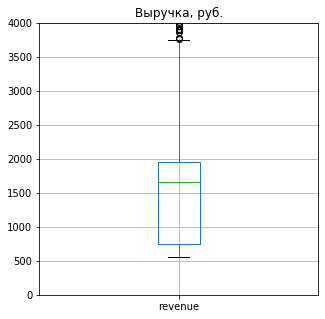

In [37]:
pivot.boxplot(column='revenue',figsize=(5,5))
plt.ylim(0, 4000)
plt.title("Выручка, руб.")
pivot['revenue'].describe()

Основная часть выручки по тарифам лежит в границах примерно до 3750 руб.

Добавим функцию по удалению выбросов.

In [38]:
def emissions(data, field):
    #функция для отбора выбросов с помощью межквартильного размаха
    before_size = len(data[field])
    q1, q3 = data[field].quantile(0.25), data[field].quantile(0.75)
    iqr = q3-q1
    data = data.query(f'@q1 - 1.5*@iqr < {field} and @q3 + 1.5*@iqr > {field}')
    after_size = len(data[field])
    percent_part = (before_size - after_size)/before_size
    print(q1-1.5*iqr,q3+1.5*iqr)
    print(f'Удалено выбросов: {before_size - after_size} ({percent_part:.1%})')

In [39]:
emissions(pivot, 'calls')

-178.5 1049.5
Удалено выбросов: 63 (2.0%)


In [40]:
emissions(pivot, 'traffic')

1.0 33.0
Удалено выбросов: 150 (4.7%)


In [41]:
emissions(pivot, 'message')

-63.0 129.0
Удалено выбросов: 95 (3.0%)


In [42]:
emissions(pivot, 'revenue')

-1050.0 3750.0
Удалено выбросов: 46 (1.4%)


**Вывод**

На этапе повторной проверки допущенных значений после проведения группировки из таблицы были удалены выбросы по следующим колонкам:
- `calls` удалены значения свыше 1049.5 мин., что составило 2% от всех значений; 
- `traffic` удалены значения свыше 33 гб, что составило 4.7% от всех значений; 
- `message` удалены значения свыше 95 шт., что составило 3% от всех значений; 
- `revenue` удалены значения свыше 3750 руб., что составило 1,4% от всех значений.


## Исследовательский анализ данных
<a id="analysis_id"></a>

Исходя из цели исследования требуется проанализировать поведение Клиентов на основании предоставленной выборки и опеределить какой тариф приносит больше денег компании "Мегалайн".

Проверим гипотезы о том,что:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Опишем поведение клиентов оператора, исходя из выборки.
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
Посчитаем среднее количество, дисперсию и стандартное отклонение.
Построим гистограммы.
Опишем распределения.

In [43]:
pivot.query('tariff=="smart"').describe()

,user_id,month,calls,traffic,message,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over,traffic_over,message_over,revenue
count,"2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00"
mean,"1,246.56",8.34,417.75,16.32,33.37,50.00,15.00,500.00,550.00,200.00,3.00,3.00,41.59,2.99,5.80,"1,289.64"
std,146.11,2.93,190.48,5.76,28.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,84.66,3.68,13.44,818.37
min,"1,001.00",0.00,0.00,0.00,0.00,50.00,15.00,500.00,550.00,200.00,3.00,3.00,0.00,0.00,0.00,550.00
25%,"1,121.00",6.00,282.00,13.00,10.00,50.00,15.00,500.00,550.00,200.00,3.00,3.00,0.00,0.00,0.00,550.00
50%,"1,240.00",9.00,421.50,17.00,28.00,50.00,15.00,500.00,550.00,200.00,3.00,3.00,0.00,2.00,0.00,"1,021.00"
75%,"1,376.00",11.00,545.00,20.00,51.00,50.00,15.00,500.00,550.00,200.00,3.00,3.00,45.00,5.00,1.00,"1,750.00"
max,"1,499.00",12.00,"1,435.00",38.00,143.00,50.00,15.00,500.00,550.00,200.00,3.00,3.00,935.00,23.00,93.00,"6,770.00"


Среднее значение для пользователя тарифа смарт:
- `количество минут` 417.75;
- `использовано трафика` 16.32;
- `количество использованных смс` 33.37;
- `количество использованных смс` 1289.64.


In [44]:
pivot.query('tariff=="ultra"').describe()

,user_id,month,calls,traffic,message,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over,traffic_over,message_over,revenue
count,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00
mean,"1,262.96",8.24,526.09,19.47,49.31,"1,000.00",30.00,"3,000.00","1,950.00",150.00,1.00,1.00,0.00,0.80,0.00,"2,070.03"
std,140.69,2.88,317.89,9.87,47.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.51,0.00,376.02
min,"1,000.00",0.00,0.00,0.00,0.00,"1,000.00",30.00,"3,000.00","1,950.00",150.00,1.00,1.00,0.00,0.00,0.00,"1,950.00"
25%,"1,143.00",6.00,282.50,12.00,6.00,"1,000.00",30.00,"3,000.00","1,950.00",150.00,1.00,1.00,0.00,0.00,0.00,"1,950.00"
50%,"1,277.00",9.00,518.00,19.00,38.00,"1,000.00",30.00,"3,000.00","1,950.00",150.00,1.00,1.00,0.00,0.00,0.00,"1,950.00"
75%,"1,381.00",11.00,751.75,27.00,78.75,"1,000.00",30.00,"3,000.00","1,950.00",150.00,1.00,1.00,0.00,0.00,0.00,"1,950.00"
max,"1,495.00",12.00,"1,673.00",49.00,224.00,"1,000.00",30.00,"3,000.00","1,950.00",150.00,1.00,1.00,0.00,19.00,0.00,"4,800.00"


Среднее значение для пользователя тарифа ультра:
- `количество минут` 526.09;
- `использовано трафика` 19.47;
- `количество использованных смс` 49.31;
- `выручка` 2070,03.


Посчитаем дисперсию,стандартное отклонение и среднее для количества звонков,использованного трафика и смс по каждому тарифу.

In [45]:
pivot.pivot_table(index='tariff',values=['calls','traffic','message','revenue'],aggfunc=['mean','var','std','median'])

mean                                 var                              \
        calls message  revenue traffic      calls  message    revenue traffic   
tariff                                                                          
smart  417.75   33.37 1,289.64   16.32  36,281.39   796.96 669,730.76   33.13   
ultra  526.09   49.31 2,070.03   19.47 101,052.49 2,285.42 141,387.71   97.38   

          std                         median                           
        calls message revenue traffic  calls message  revenue traffic  
tariff                                                                 
smart  190.48   28.23  818.37    5.76 421.50   28.00 1,021.00   17.00  
ultra  317.89   47.81  376.02    9.87 518.00   38.00 1,950.00   19.00

Построим график по умолчанию с оценкой плотности ядра и гистограммой с размером ячейки по количеству звонков.

Text(0.5, 1.0, 'График с оценкой плотности ядра и гистограммой с размером ячейки по количеству звонков., мин.')

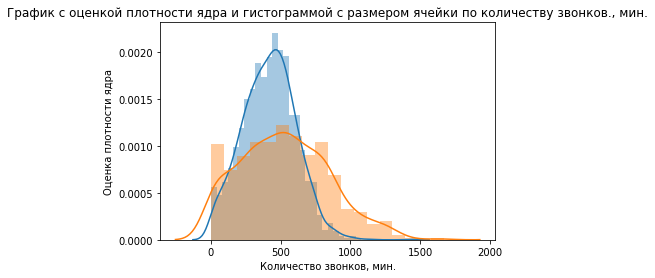

In [46]:
bx = sns.distplot(pivot.query('tariff=="smart"')['calls'])
ax = sns.distplot(pivot.query('tariff=="ultra"')['calls'])
plt.ylabel("Оценка плотности ядра")
plt.xlabel("Количество звонков, мин.")
plt.title("График с оценкой плотности ядра и гистограммой с размером ячейки по количеству звонков., мин.")



Text(0.5, 1.0, 'Количество звонков по тарифу Smart, мин.')

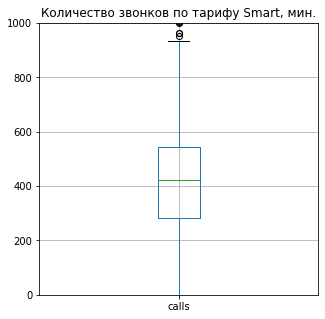

In [47]:
pivot.query('tariff=="smart"').boxplot(column='calls',figsize=(5,5))
plt.ylim(0, 1000)
plt.title("Количество звонков по тарифу Smart, мин.")

Text(0.5, 1.0, 'Количество звонков по тарифу Ultra, мин.')

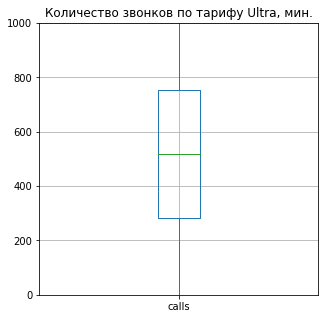

In [48]:
pivot.query('tariff=="ultra"').boxplot(column='calls',figsize=(5,5))
plt.ylim(0, 1000)
plt.title("Количество звонков по тарифу Ultra, мин.")

Исходя из гистрограммы по количеству звонков мы наблюдаем распределение очень близкое к нормальному обоим тарифам. 
По тарифу **"Смарт"** большинство пользователей по количеству использованных минут укладываются в стандартный пакет (500 минут), но есть и те,кто тратят более 500 минут.
По тарифу **"Ультра"** пользователи укладываются в стандартный пакет (3000 минут)

Построим график по умолчанию с оценкой плотности ядра и гистограммой с размером ячейки  по количеству использованного трафика.

Text(0.5, 1.0, 'График с оценкой плотности ядра и гистограммой с размером ячейки по израсходованному трафику, гб')

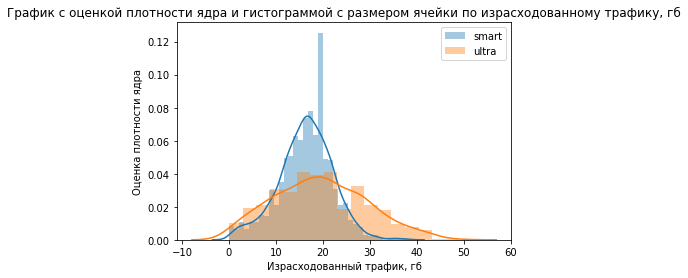

In [49]:
bx = sns.distplot(pivot.query('tariff=="smart"')['traffic'],label='smart')
ax = sns.distplot(pivot.query('tariff=="ultra"')['traffic'],label='ultra')
plt.legend()
plt.ylabel("Оценка плотности ядра")
plt.xlabel("Израсходованный трафик, гб")
plt.title("График с оценкой плотности ядра и гистограммой с размером ячейки по израсходованному трафику, гб")


Text(0.5, 1.0, 'Количество израсходованного трафика по тарифу Smart, гб')

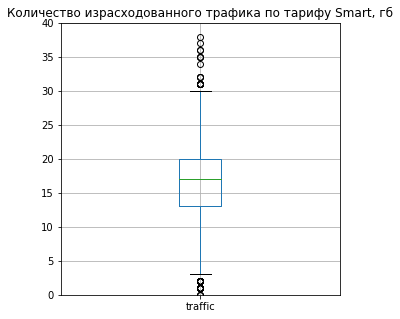

In [50]:
pivot.query('tariff=="smart"').boxplot(column='traffic',figsize=(5,5))
plt.ylim(0, 40)
plt.title("Количество израсходованного трафика по тарифу Smart, гб")

Text(0.5, 1.0, 'Количество израсходованного трафика по тарифу Ultra, гб')

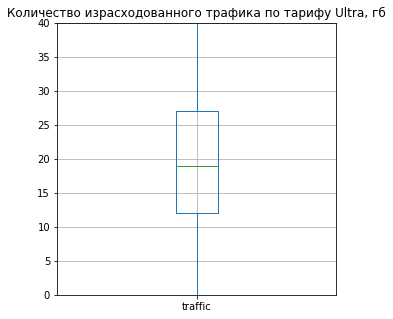

In [51]:
pivot.query('tariff=="ultra"').boxplot(column='traffic',figsize=(5,5))
plt.ylim(0, 40)
plt.title("Количество израсходованного трафика по тарифу Ultra, гб")

Исходя из гистрограммы по израсходованному трафику мы наблюдаем распределение близкое к нормальному по обоим тарифам. 
По тарифу Smart большая часть пользователь превышает расходы по пакету, расходуя около 17 гб.
Пользователи по тарифу Ultra укладываются в стандартные пакеты.

Построим график по умолчанию с оценкой плотности ядра и гистограммой с размером ячейки  по количеству использованных смс.

Text(0.5, 1.0, 'График с оценкой плотности ядра и гистограммой с размером ячейки по количеству использованных смс, шт.')

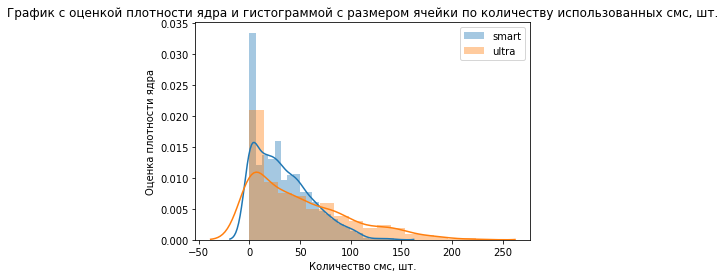

In [52]:
bx = sns.distplot(pivot.query('tariff=="smart"')['message'],label='smart')
ax = sns.distplot(pivot.query('tariff=="ultra"')['message'],label='ultra')
plt.legend()
plt.ylabel("Оценка плотности ядра")
plt.xlabel("Количество смс, шт.")

plt.title("График с оценкой плотности ядра и гистограммой с размером ячейки по количеству использованных смс, шт.")




Text(0.5, 1.0, 'Нормальное распределение с помощью гистограммы и распределения по Гауссу с максимальной вероятностью по количеству использованных смс, шт.')

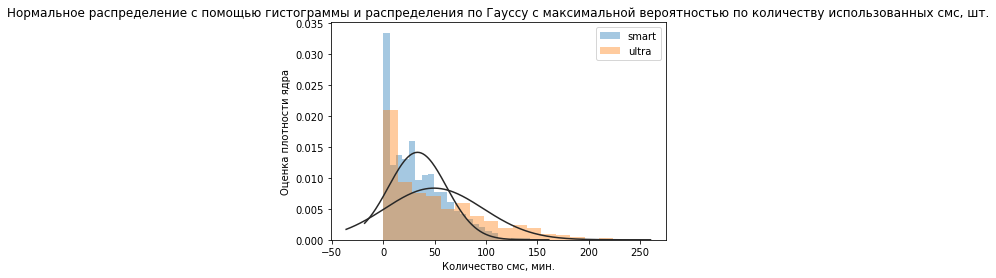

In [53]:
ax = sns.distplot(pivot.query('tariff=="smart"')['message'], fit=norm, kde=False,label='smart')
bx = sns.distplot(pivot.query('tariff=="ultra"')['message'], fit=norm, kde=False,label='ultra')
plt.legend()
plt.ylabel("Оценка плотности ядра")
plt.xlabel("Количество смс, мин.")
plt.title("Нормальное распределение с помощью гистограммы и распределения по Гауссу с максимальной вероятностью по количеству использованных смс, шт.")


Text(0.5, 1.0, 'Количество израсходованных смс по тарифу Smart, шт.')

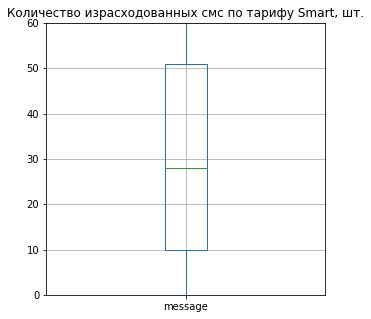

In [54]:
pivot.query('tariff=="smart"').boxplot(column='message',figsize=(5,5))
plt.ylim(0, 60)
plt.title("Количество израсходованных смс по тарифу Smart, шт.")

Text(0.5, 1.0, 'Количество израсходованных смс по тарифу Ultra, шт.')

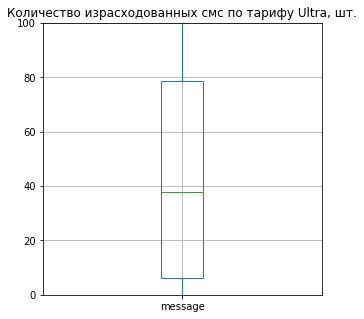

In [55]:
pivot.query('tariff=="ultra"').boxplot(column='message',figsize=(5,5))
plt.ylim(0, 100)
plt.title("Количество израсходованных смс по тарифу Ultra, шт.")

Исходя из гистрограммы по количеству израсходованных смс мы наблюдаем распределение скошенное влево.
Это связано с тем,что отправка смс не сильно распространена. Практически все пользователи укладываются в рамках пакета.


Text(0.5, 0, 'Выручка, руб.')

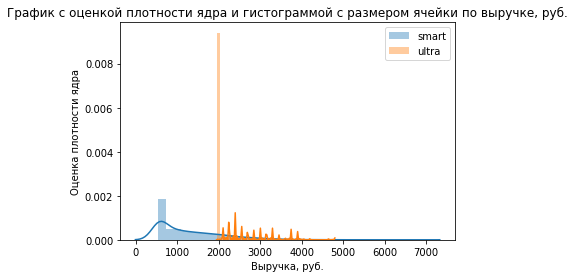

In [56]:
bx = sns.distplot(pivot.query('tariff=="smart"')['revenue'], label='smart')
ax = sns.distplot(pivot.query('tariff=="ultra"')['revenue'],label='ultra')
plt.legend()
plt.title("График с оценкой плотности ядра и гистограммой с размером ячейки по выручке, руб.")
plt.ylabel("Оценка плотности ядра")
plt.xlabel("Выручка, руб.")


Text(0.5, 0, 'Выручка, руб.')

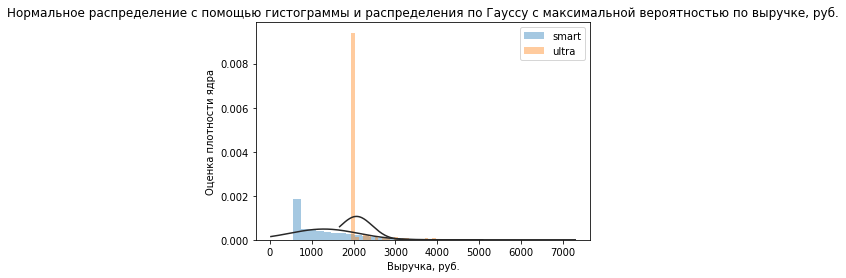

In [57]:
ax = sns.distplot(pivot.query('tariff=="smart"')['revenue'], fit=norm, kde=False,label='smart')
bx = sns.distplot(pivot.query('tariff=="ultra"')['revenue'], fit=norm, kde=False,label='ultra')
plt.legend()
plt.title("Нормальное распределение с помощью гистограммы и распределения по Гауссу с максимальной вероятностью по выручке, руб.")
plt.ylabel("Оценка плотности ядра")
plt.xlabel("Выручка, руб.")

Text(0.5, 1.0, 'Выручка по тарифу Smart, руб.')

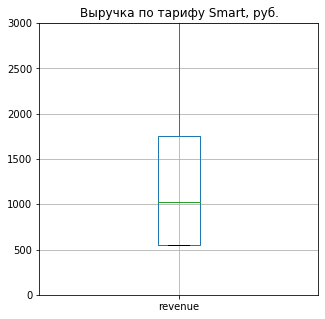

In [58]:
pivot.query('tariff=="smart"').boxplot(column='revenue',figsize=(5,5))
plt.ylim(0, 3000)
plt.title("Выручка по тарифу Smart, руб.")

Text(0.5, 1.0, 'Выручка по тарифу Ultra, руб.')

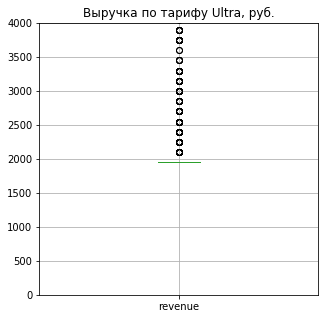

In [59]:
pivot.query('tariff=="ultra"').boxplot(column='revenue',figsize=(5,5))
plt.ylim(0, 4000)
plt.title("Выручка по тарифу Ultra, руб.")

График выручки по тарифу Smart скошен влево, так как основная часть пользователей укладывается в имеющейся пакет, несмотря на это медиана зафиксирована на 1,021 руб. это вызвано перерасходом по пакету остальных пользователей этого тарифа.
По тарифу ультра мы наблюдаем четко устоявшуюся выручку, значение медианы 1,950.00, исходя из этого можно сделать вывод что большая часть пользователей тарифа Ultra укладывается в пакет услуг.

Выполним анализ выручки по каждому тарифу.

Text(0.5, 0, 'Месяц')

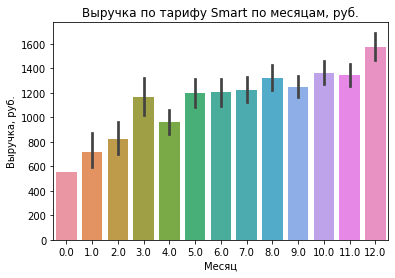

In [60]:
#sns.set_theme(style="whitegrid")
ax = sns.barplot(x="month", y="revenue", data=pivot.query('tariff=="smart"'))
plt.title("Выручка по тарифу Smart по месяцам, руб.")
plt.ylabel("Выручка, руб.")
plt.xlabel("Месяц")

Text(0.5, 0, 'Месяц')

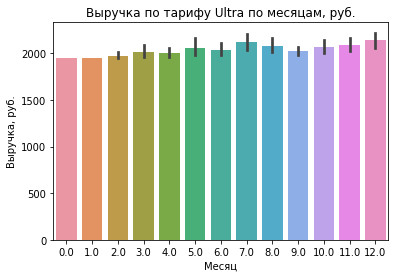

In [61]:
#sns.set_theme(style="whitegrid")
ax = sns.barplot(x="month", y="revenue", data=pivot.query('tariff=="ultra"'))
plt.title("Выручка по тарифу Ultra по месяцам, руб.")
plt.ylabel("Выручка, руб.")
plt.xlabel("Месяц")

Если по тарифу Ultra мы можем наблюдать примерно стабильное распределения выручки, то по тарифу Smart выручка увеличивается к концу года. Это может быть вызвано увеличеним количества пользователей превышающих расходы по стандартному пакету услуг или увеличением расходов.

Проверим гипотезу о том,что значения средней выручки пользователей тарифов «Ультра» и «Смарт» равны между собой.
Альтернативная гипотеза звучить так: "Средние значения выручки пользователей тарифов "Ультра" и "Смарт" не равны между собой." 

In [62]:
results = st.ttest_ind( pivot.query('tariff=="ultra"')['revenue'],
pivot.query('tariff=="smart"')['revenue'],equal_var=False)
alpha=0.05
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу


Гипотеза о том,что значения средней выручки пользователей тарифа «Ультра» и «Смарт» равны между собой отвергнута. Следовательно можно предположить,что средние значения выручки пользователей тарифа «Ультра» и «Смарт» равны между собой.


Выполним проверку гипотезы о том,что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
Альтернативная гипотеза звучит так: "Средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов"
Перед проверкой гипотезы проверим есть ли разница дисперсий 2 выборок.

In [63]:
pivot.query('city=="Москва"').pivot_table(index='city',values='revenue',aggfunc=['mean','var','std','median'])


,mean,var,std,median
,revenue,revenue,revenue,revenue
city,,,,
Москва,"1,546.71","565,636.47",752.09,"1,750.00"


In [64]:
pivot.query('city!="Москва"')['revenue'].var()
pivot.query('city!="Москва"')['revenue'].mean()

1524.7251439539348

In [65]:
results = st.ttest_ind( pivot.query('city=="Москва"')['revenue'],
pivot.query('city!="Москва"')['revenue'],equal_var=False)
alpha=0.05
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Гипотеза о том,что среднее значение выручки жителей Москвы и других регионов равна не была отвергнута.

**Вывод**

`В рамках исследования были изучены показатели:`

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Среднее значение для пользователя тарифа смарт:
- `количество минут` 417.75;
- `использовано трафика` 16.32;
- `количество использованных смс` 33.37;
- `выручка` 1289.64.

Среднее значение для пользователя тарифа ультра:
- `количество минут` 526.09;
- `использовано трафика` 19.47;
- `количество использованных смс` 49.31;
- `выручка` 2070,03.

Помесячная выручка по пользователям по тарифу Ultra находится на уровне 2000 руб.
Помесячная выручка по пользователям по тарифу Smart в начале года находится на уровне 700 руб. и увеличивается к концу года до уровня 1600 руб.

Гипотеза о том что средняя выручка по тарифам Smart Ultra различается не была отвергнута (вероятность 1.-250)
Гипотеза о том,что средняя выручка жителей Москвы и других городов различается была отвергнута с вероятностью равной 0.5216952110000278.

## Общий вывод
<a id="conclusion_id"></a>

В результате исследования было изучено поведение пользователей 2 тарифов Компании "Мегалайн".

Пользователи тарифа **Smart** по количеству звонков в большинстве случев укладываются в пакет минут в рамках тарифа (500 минут),часть пользователей превышает данный лимит проговаривая до 545 минут. По количеству использованного трафика основная часть пользователей превышает лимит в 15 гб и тратит около 17 гб, также около четверти пользователей превышает лимит до 20 гб.
Несмотря на то,что большая часть пользователей укладывается в рамках тарифа и выручка по большей части пользователей зафиксирована на уровне 500 руб., средняя выручка составила 1289,64 руб. Выручка по пользователям,которые не укладываются в рамках пакета сильно влияет на значение средней выручки.
Помесячное распределение средней выручки имеет явное повышение с начала года к декабрю, в январе зафиксирована на уровне 700 руб.,к декабрю она достигает уровня в 1600 руб. Это может быть связано с увеличением количества пользователей,которые не укладываются в рамках пакета или увеличением расходов.

Пользователи тарифа **Ultra** в основном укладываются в рамках зафиксированных пакетов услуг, о чем и свидетельствует небольшое отклонение средней выручки всего на 120 руб., значение медианы по выручке в 1950 руб. свидетельствует о том,что большая часть пользователей все же укладывается в тариф.
Помесячное распределение выручки по месяца не имеет явных отклоненеий и зафикирована на средней выручке в размере 2000 руб.

Для Компании "Мегалайн" **выгоднее продвигать продажи по тарифу Ultra**, так как средняя выручка по данному тарифу значительно выше,чем по тарифу Smart на **780 руб.**

В рамках исседования были выполнены проверки 2 гипотез:
- `Гипотеза о том,что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.`
При проверке двух генеральных совокупностей гипотеза о различии средней выручки не была отвергнута, следовательно можно предположить,что средняя выручка данных тарифов различна.
-`Гипотеза о разности среднего значения выручки жителей Москвы и других городов.`
При проверке двух генеральных совокупностей гипотеза о различии средней выручки пользователей в городе Москве и в других городах отвергнута, так как вероятность их равенства равна 0.5216952110000278. Следовательно можно сделать вывод,что уровень расходов пользователей на услуги связи не имеет существенного значения. 
